<a href="https://colab.research.google.com/github/jonasd4/pathology-worked-through/blob/main/cancer_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Worked-Through Example: Cancer classification from images**

This is the code for the first worked-through example: **Cancer classification from images** in our paper *Explainable AI for Precision Pathology*. We will train a model to classify different colorectal patches into tissue classes. The tissue classes are: Adipose (ADI), background (BACK), debris (DEB), lymphocytes (LYM), mucus (MUC), smooth muscle (MUS), normal colon mucosa (NORM), cancer-associated stroma (STR), colorectal adenocarcinoma epithelium (TUM).

In [ ]:
# Clone the repository with the code
!git clone https://github.com/jonasd4/pathology-worked-through

In [1]:
# Imports
import matplotlib.pyplot as plt
from PIL import Image
import os
import random
import pandas as pd
from os.path import join
from tqdm.notebook import tqdm
import numpy as np

After cloning the repository, we need to download the patch dataset which we want to investigate. The original dataset was published by the authors on [Zenodo](https://zenodo.org/record/1214456#.Y_nbuuzMK3J). To speed up the download process, we download a copy from a Google Drive.

In [ ]:
## Download data
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1HSANsreKw3sxU7-dLr7c6_5ovexb6LR3' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1HSANsreKw3sxU7-dLr7c6_5ovexb6LR3" -O CRC-VAL-HE-7K.zip && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=14SHepFBNGhNlGhncoT2bvTy5iNkgw9iT' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=14SHepFBNGhNlGhncoT2bvTy5iNkgw9iT" -O NCT-CRC-HE-100K-NONORM.zip && rm -rf /tmp/cookies.txt
!unzip CRC-VAL-HE-7K.zip
!unzip NCT-CRC-HE-100K-NONORM.zip

In [ ]:
!unzip NCT-CRC-HE-100K-NONORM.zip

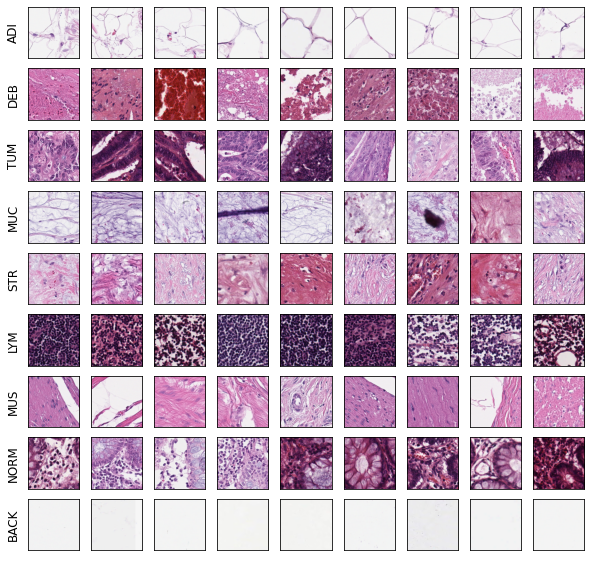

In [8]:
# Show example images from the dataset

path = 'NCT-CRC-HE-100K-NONORM'
classes = list(os.listdir(path))
samples_per_class = 9

fig, ax = plt.subplots(len(classes), samples_per_class)
fig.set_size_inches((10, 10))
for row_idx, cls in enumerate(classes):
  files = os.listdir(os.path.join(path, cls))
  random.shuffle(files)
  for col_idx, file in enumerate(files[:samples_per_class]):
    img = Image.open(os.path.join(path, cls, file))
    ax[row_idx][col_idx].imshow(img)
    ax[row_idx][col_idx].set_yticklabels([])
    ax[row_idx][col_idx].set_xticklabels([])
    ax[row_idx][col_idx].set_xticks([])
    ax[row_idx][col_idx].set_yticks([])
    ax[row_idx][0].set_ylabel(cls, rotation=90, size='large')

## Split the data
We now split the data into a train, test and validation split. The training set  will be 50% of the images and the validation and test set each 25%.

In [ ]:
def generate_sub_splits(subdir='NCT-CRC-HE-100K', seed=0):
    path = os.path.join(subdir)
    patches = []
    for cls in classes:
        cls_path = join(path, cls)
        if cls.endswith('.csv'):
              continue
        for patch in os.listdir(cls_path):
            patches.append({
                'file_path': join(cls, patch),
                'cls': cls,
                'label': classes.index(cls),
            })
    df = pd.DataFrame(patches)
    train, other = train_test_split(df, test_size=0.5, random_state=seed)
    test, validation = train_test_split(other, test_size=0.5, random_state=seed)
    df.to_csv(os.path.join(path, 'all.csv'))
    train.to_csv(os.path.join(path, 'train.csv'))
    test.to_csv(os.path.join(path, 'test.csv'))
    validation.to_csv(os.path.join(path, 'test.csv'))

generate_sub_splits('NCT-CRC-HE-100K-NONORM')
generate_sub_splits('CRC-VAL-HE-7K')

## Train the model
We will now train the model. We use Pytorch and [Pytorch Lightning](https://pytorch-lightning.readthedocs.io/en/stable/) to train our model. The training takes about 1 hour. To continue right away, you can also downlaod the trained model immediately below and follow the rest of the worked-through example.


In [ ]:
%run train.py --logdir logs/baseline \
--batch_size 32 \
--learning-rate 0.01 \
--weight-decay 0.001 \
--epochs 300 \
--classes 9 \
--loss ce \
--train-split train \
--test-split test \
--train-path NCT-CRC-HE-100K-NONORM \
--test-path NCT-CRC-HE-100K-NONORM \
--val-interval 10 \
--num_workers 4 \
--augmentation v2

In [ ]:
# TODO: Download the model

## Evaluate
After training the model, we evaluate the model which best performed on the validation set on the test set. Further, we also evaluate on the external test set which 

## Investigate the model with XAI
We use the [zennit](https://github.com/chr5tphr/zennit) library to compute explanation heatmaps. for some selected images and show the heatmaps.

## Look at the color spectrum of the images

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


path = 'NCT-CRC-HE-100K-NONORM'
df = pd.read_csv(join(path, 'train.csv'))

# we sample 2000 random samples for better visualization purposes
subset = df.sample(2000)

def compute_color_means():
  colors = []
  for idx, row in tqdm(subset.iterrows()):
      img = Image.open(join(path, row['file_path']))
      img_array = np.asarray(img)
      avg_color_per_row = np.average(np.asarray(img), axis=0)
      avg_color = np.average(avg_color_per_row, axis=0)
      colors.append(avg_color)
  colors = np.array(colors)
  return colors

X = colors
y = subset.label
scaler = StandardScaler()
scaler.fit(X)   
pca = PCA()
x_new = pca.fit_transform(X)

def pca_biplot(score, coeff, labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1./(xs.max() - xs.min())
    scaley = 1./(ys.max() - ys.min())
    
    for label in subset.label.unique():
        legend_label = str(subset[subset.label == label].cls.unique()[0])
        mask = subset.label == label
        scatter = plt.scatter(xs[mask] * scalex, ys[mask] * scaley, alpha=0.1, label=legend_label)
    
    colors = ['red', 'green', "blue"]
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], color = 'black', alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'black', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.axis("off")
    leg = plt.legend(loc="upper right", fontsize=8)
    for lh in leg.legendHandles:
        lh.set_alpha(1)

pca_biplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]), labels=['Red', 'Green', "Blue"])
plt.show()

## Stain normalization
Now that we identified that color seems to be a strong problem in this case, we can use stain normalization to 

In [ ]:
%run stain.py --ref Ref.png --img NCT-CRC-HE-100K-NONORM \
--out NCT-CRC-HE-100K-stain-norm

## Train the improved model

In [ ]:
%run train.py --logdir logs/improved \
--batch_size 32 \
--learning-rate 0.01 \
--weight-decay 0.001 \
--epochs 300 \
--classes 9 \
--loss ce \
--train-split train \
--test-split test \
--train-path NCT-CRC-HE-100K-stain-norm \
--test-path NCT-CRC-HE-100K-stain-norm \
--val-interval 10 \
--num_workers 4 \
--augmentation v3 # now we use also color augmentations